In [ ]:
from google.colab import files

# Upload both agg_gen.csv and agg_load.csv
uploaded = files.upload()


Saving agg_gen.csv to agg_gen.csv
Saving agg_load.csv to agg_load.csv


Loss of Load Hours: 34398 out of 64505 intervals
Avg Reserve Margin: -0.01%


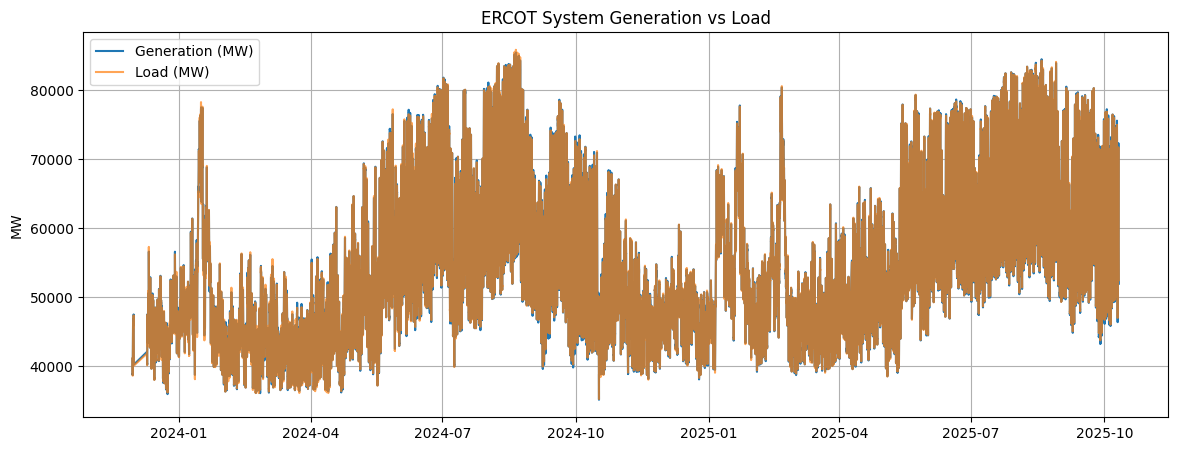

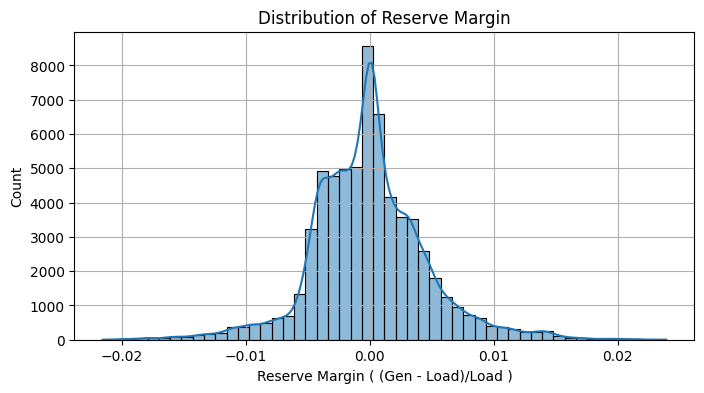

In [ ]:
!pip install pandas matplotlib seaborn tqdm

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# gen and load files
gen_df = pd.read_csv("agg_gen.csv")
load_df = pd.read_csv("agg_load.csv")

# Clean timestamps
gen_df['SCEDTimestamp'] = pd.to_datetime(gen_df['SCEDTimestamp'])
load_df['SCEDTimestamp'] = pd.to_datetime(load_df['SCEDTimestamp'])

# Select relevant columns
gen_df = gen_df[['SCEDTimestamp', 'sumGenTelemMW']]
load_df = load_df[['SCEDTimestamp', 'aggLoadSummary']]

# Merge generation and load data
df = pd.merge(gen_df, load_df, on='SCEDTimestamp', how='inner')

# Rename
df.rename(columns={
    'sumGenTelemMW': 'generation_MW',
    'aggLoadSummary': 'load_MW'
}, inplace=True)

# Compute reserve margin
df['reserve_margin'] = (df['generation_MW'] - df['load_MW']) / df['load_MW']

# Identify loss-of-load hours
df['load_exceeds_generation'] = df['load_MW'] > df['generation_MW']
lolh = df['load_exceeds_generation'].sum()

print(f"Loss of Load Hours: {lolh} out of {len(df)} intervals")
print(f"Avg Reserve Margin: {df['reserve_margin'].mean()*100:.2f}%")

# Plot generation vs load
plt.figure(figsize=(14,5))
plt.plot(df['SCEDTimestamp'], df['generation_MW'], label='Generation (MW)')
plt.plot(df['SCEDTimestamp'], df['load_MW'], label='Load (MW)', alpha=0.7)
plt.title("ERCOT System Generation vs Load")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

# Histogram of reserve margin
plt.figure(figsize=(8,4))
sns.histplot(df['reserve_margin'], bins=50, kde=True)
plt.title("Distribution of Reserve Margin")
plt.xlabel("Reserve Margin ( (Gen - Load)/Load )")
plt.grid(True)
plt.show()


In [ ]:
df_gen = pd.read_csv("agg_gen.csv")

mean_wind = df_gen['sumBasePointWGR'].mean()
std_wind = df_gen['sumBasePointWGR'].std()
print(f"Mean Wind Generation: {mean_wind:.2f} MW")
print(f"Std Dev Wind Generation: {std_wind:.2f} MW")

Mean Wind Generation: 12761.33 MW
Std Dev Wind Generation: 6849.42 MW


In [ ]:
mean_load = load_df['aggLoadSummary'].mean()
std_load = load_df['aggLoadSummary'].std()

mean_gen = gen_df['sumGenTelemMW'].mean()
std_gen = gen_df['sumGenTelemMW'].std()

print(f"Mean Load: {mean_load:.2f} MW")
print(f"Load Std Dev: {std_load:.2f} MW")
print(f"Mean Generation: {mean_gen:.2f} MW")
print(f"Generation Std Dev: {std_gen:.2f} MW")


Mean Load: 54724.22 MW
Load Std Dev: 10826.26 MW
Mean Generation: 54720.99 MW
Generation Std Dev: 10828.12 MW


In [ ]:
df['net_margin'] = df['generation_MW'] - df['load_MW']
print("Worst shortfall:", df['net_margin'].min())
print("Average shortfall:", df['net_margin'].mean())
print("Max surplus:", df['net_margin'].max())

Worst shortfall: -1144.5099999999948
Average shortfall: -3.2341144953104526
Max surplus: 1072.5624000000025


Block-Bootstrap on TOP 10% Highest-Load Intervals
n_total_intervals: 64505
critical_frac: 0.100000
n_critical_intervals: 6451
dt_hours: 0.247500
num_critical_blocks: 234  (mean block length: 27.57)

-- Baseline reliability on sampled critical set (K=0) --
LOLH_hours_p05: 806.602500
LOLH_hours_p50: 862.290000
LOLH_hours_p95: 917.235000
EUE_MWh_p50:    196910.205088
LOLP_interval_p50: 0.540071
Monte Carlo Results on TOP 10% Highest-Load Hours (block bootstrap)
LOLH_hours  p05 / p50 / p95: 806.602  862.290  917.235
EUE_MWh     p05 / p50 / p95: 167556.0  196910.2  228578.4
LOLP_interval (median):      0.540
CapNeeded_MW to clear (p95): 1144.3

Saved: bb_mc_distributions_topload.csv


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


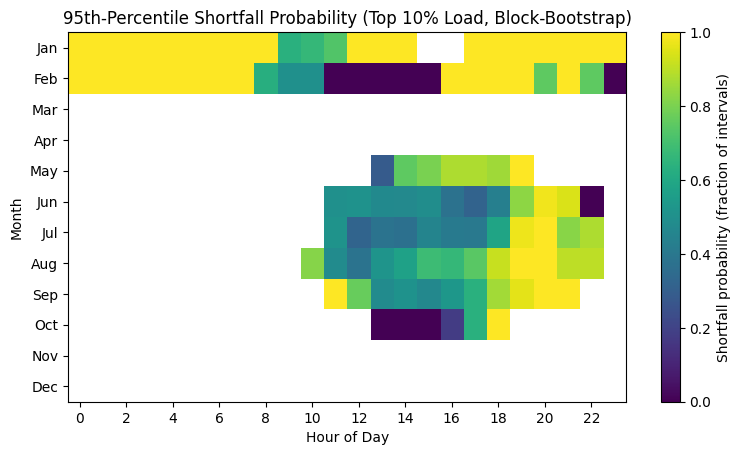

In [ ]:
if "df" in globals() and {"SCEDTimestamp","sumGenTelemMW","aggLoadSummary"}.issubset(df.columns):
    merged = df.copy()
else:
    if "gen_df" not in globals() or "load_df" not in globals():
        raise RuntimeError("Need either a merged `df` with required columns or `gen_df` + `load_df` loaded.")
    _g = gen_df[["SCEDTimestamp","sumGenTelemMW"]].copy()
    _l = load_df[["SCEDTimestamp","aggLoadSummary"]].copy()
    merged = pd.merge(_g, _l, on="SCEDTimestamp", how="inner")

# 1) Sort & infer interval length (hours) for LOLH/EUE
merged = merged.sort_values("SCEDTimestamp").reset_index(drop=True)
if len(merged) < 2:
    raise ValueError("Need at least 2 rows to infer time step.")

dt_hours = (merged["SCEDTimestamp"].iloc[1] - merged["SCEDTimestamp"].iloc[0]).total_seconds() / 3600.0
if dt_hours <= 0:
    diffs = merged["SCEDTimestamp"].diff().dropna().dt.total_seconds().values / 3600.0
    dt_hours = float(np.median(diffs))
if dt_hours <= 0:
    raise ValueError("Could not infer a positive time step from timestamps.")

# 2) Define critical set = TOP 10% by LOAD (these are the highest-load intervals)
CRITICAL_FRAC = 0.10
n_total = len(merged)
n_crit  = max(1, int(np.ceil(CRITICAL_FRAC * n_total)))
critical_idx = merged["aggLoadSummary"].nlargest(n_crit).index

# 3) "critical runs" and margin blocks
margin_full = (merged["sumGenTelemMW"].to_numpy() - merged["aggLoadSummary"].to_numpy())
pos = np.arange(n_total)
crit_mask = np.zeros(n_total, dtype=bool); crit_mask[np.asarray(critical_idx)] = True
crit_pos = pos[crit_mask]
if crit_pos.size == 0:
    raise ValueError("No critical intervals found.")

splits = np.where(np.diff(crit_pos) > 1)[0] + 1
runs = np.split(crit_pos, splits)
blocks = [margin_full[r] for r in runs if r.size > 0]
if len(blocks) == 0:
    raise ValueError("No non-empty critical blocks constructed.")
block_lengths = np.array([len(b) for b in blocks], dtype=int)
weights = block_lengths / block_lengths.sum()

# 4) RNG + sampler (block-bootstrap)
rng = np.random.default_rng(42)

def sample_critical_block_bootstrap(n_needed: int) -> np.ndarray:
    picked = []; total = 0
    while total < n_needed:
        i = int(rng.choice(len(blocks), p=weights))
        b = blocks[i]
        picked.append(b)
        total += len(b)
    out = np.concatenate(picked, axis=0)
    return out[:n_needed]

# 5) Monte Carlo bootstrap on the critical intervals (block bootstrap)
N_TRAJ = 10_000
BATCH  = 200

lolh_hours = np.empty(N_TRAJ, dtype=float)   # Loss of Load Hours within the critical set
eue_mwh    = np.empty(N_TRAJ, dtype=float)   # Expected Unserved Energy within the critical set
lolp_int   = np.empty(N_TRAJ, dtype=float)   # fraction of intervals short
worst_mw   = np.empty(N_TRAJ, dtype=float)   # worst shortfall MW among sampled critical intervals
cap_needed = np.empty(N_TRAJ, dtype=float)   # firm MW to eliminate all shortfalls in our sample

done = 0
while done < N_TRAJ:
    b = min(BATCH, N_TRAJ - done)
    samp = np.vstack([sample_critical_block_bootstrap(n_crit) for _ in range(b)])  # (b, n_crit)

    short = (samp < 0.0)
    lolh_hours[done:done+b] = short.sum(axis=1) * dt_hours
    eue_mwh[done:done+b]    = (-samp * short).sum(axis=1) * dt_hours
    lolp_int[done:done+b]   = short.mean(axis=1)

    worst = samp.min(axis=1)
    worst_mw[done:done+b]   = worst
    cap_needed[done:done+b] = np.maximum(0.0, -worst)
    done += b

# 6) Summary
def q(a, p): return float(np.quantile(a, p))

# Diagnostics + baseline stats:
print("Block-Bootstrap on TOP 10% Highest-Load Intervals")
print(f"n_total_intervals: {n_total}")
print(f"critical_frac: {CRITICAL_FRAC:.6f}")
print(f"n_critical_intervals: {n_crit}")
print(f"dt_hours: {dt_hours:.6f}")
print(f"num_critical_blocks: {len(blocks)}  (mean block length: {block_lengths.mean():.2f})\n")

print("-- Baseline reliability on sampled critical set (K=0) --")
print(f"LOLH_hours_p05: {q(lolh_hours, 0.05):.6f}")
print(f"LOLH_hours_p50: {q(lolh_hours, 0.50):.6f}")
print(f"LOLH_hours_p95: {q(lolh_hours, 0.95):.6f}")
print(f"EUE_MWh_p50:    {q(eue_mwh,    0.50):.6f}")
print(f"LOLP_interval_p50: {q(lolp_int, 0.50):.6f}")

# Monte Carlo Results:
print("Monte Carlo Results on TOP 10% Highest-Load Hours (block bootstrap)")
print(f"LOLH_hours  p05 / p50 / p95: {q(lolh_hours,0.05):.3f}  {q(lolh_hours,0.50):.3f}  {q(lolh_hours,0.95):.3f}")
print(f"EUE_MWh     p05 / p50 / p95: {q(eue_mwh,0.05):.1f}  {q(eue_mwh,0.50):.1f}  {q(eue_mwh,0.95):.1f}")
print(f"LOLP_interval (median):      {q(lolp_int,0.50):.3f}")
print(f"CapNeeded_MW to clear (p95): {q(cap_needed,0.95):.1f}")

# 7) Saving distributions
pd.DataFrame({
    "lolh_hours": lolh_hours,
    "eue_mwh": eue_mwh,
    "lolp_interval": lolp_int,
    "worst_shortfall_mw": worst_mw,
    "cap_needed_mw": cap_needed,
}).to_csv("bb_mc_distributions_topload.csv", index=False)
print("\nSaved: bb_mc_distributions_topload.csv")

# Month/hour features (from existing merged)
if "month" not in merged.columns:
    merged["month"] = merged["SCEDTimestamp"].dt.month
if "hour" not in merged.columns:
    merged["hour"]  = merged["SCEDTimestamp"].dt.hour
months = merged["month"].to_numpy()
hours  = merged["hour"].to_numpy()

# Build blocks of indices
if 'runs' in locals():
    blocks_idx = [r for r in runs if hasattr(r, "size") and r.size > 0]
else:
    # Reconstruct runs from critical_idx
    ci = np.sort(np.asarray(critical_idx))
    splits_hm = np.where(np.diff(ci) > 1)[0] + 1
    rec_runs = np.split(ci, splits_hm)
    blocks_idx = [r for r in rec_runs if r.size > 0]

if not blocks_idx:
    raise ValueError("No non-empty critical blocks constructed for heatmap.")

# Reuse weights already computed from block_lengths
weights_hm = weights

# Independent RNG for heatmap sampling
rng_hm = np.random.default_rng(12345)

def sample_indices_block_bootstrap(n_needed: int) -> np.ndarray:
    picked = []
    total = 0
    while total < n_needed:
        j = int(rng_hm.choice(len(blocks_idx), p=weights_hm))
        picked.append(blocks_idx[j])
        total += len(blocks_idx[j])
    out = np.concatenate(picked, axis=0)
    return out[:n_needed]

# Monte Carlo: per-trajectory Month×Hour shortfall fraction
HM_TRAJ = min(10000, N_TRAJ)
H = np.full((HM_TRAJ, 12, 24), np.nan, dtype=np.float32)

for i in range(HM_TRAJ):
    idx = sample_indices_block_bootstrap(n_crit)
    m   = months[idx] - 1
    h   = hours[idx]
    short = (margin_full[idx] < 0).astype(np.int32)
    tot = np.zeros((12,24), dtype=np.int32)
    bad = np.zeros((12,24), dtype=np.int32)
    np.add.at(tot, (m, h), 1)
    np.add.at(bad, (m, h), short)
    with np.errstate(divide="ignore", invalid="ignore"):
        frac = bad / tot
        frac[tot == 0] = np.nan
    H[i] = frac

heat_p95 = np.nanquantile(H, 0.95, axis=0)

def _plot_heatmap(data, title):
    fig, ax = plt.subplots(figsize=(9, 4.8))
    data_ma = np.ma.masked_invalid(data)
    im = ax.imshow(data_ma, aspect="auto", vmin=0.0, vmax=1.0)
    cbar = plt.colorbar(im)
    cbar.set_label("Shortfall probability (fraction of intervals)")
    ax.set_title(title)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Month")
    ax.set_xticks(np.arange(0,24,2))
    ax.set_yticks(np.arange(12))
    ax.set_yticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    ax.grid(False)
    plt.show()

_plot_heatmap(heat_p95, "95th-Percentile Shortfall Probability (Top 10% Load, Block-Bootstrap)")